# Binary Classification with Artificial Neural Network

This notebook implements a Convolutional Neural Network (CNN) for a binary classification task (Masculine vs. Feminine) using TensorFlow and Keras.

In [1]:
!pip install --upgrade --force-reinstall protobuf==3.20.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

2026-01-15 15:43:54.023660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768491834.214730      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768491834.271400      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768491834.732059      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768491834.732113      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768491834.732116      23 computation_placer.cc:177] computation placer alr

## 1. Configuration and Data Loading

In [3]:
# Configuration
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 15

# Paths
BASE_DIR = '/kaggle/input/anime-gender-classification/dataset'
TRAIN_CSV = os.path.join(BASE_DIR, 'train.csv')
VAL_CSV = os.path.join(BASE_DIR, 'val.csv')
SUBMISSION_FORMAT = os.path.join(BASE_DIR, 'submission_format.csv')
TRAIN_DIR = os.path.join(BASE_DIR, 'train_images')
VAL_DIR = os.path.join(BASE_DIR, 'val_images')
TEST_DIR = os.path.join(BASE_DIR, 'test_images')

# Load csv files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)

# Ensure labels are strings for binary class mode
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

Training set size: 4800
Validation set size: 600


In [4]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=VAL_DIR,
    x_col='id',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 4800 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


## 2. Model Construction

In [5]:
def build_model():
    model = Sequential([
        Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

I0000 00:00:1768491855.003880      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Training

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=max(1, len(train_df) // BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=max(1, len(val_df) // BATCH_SIZE)
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1768491859.726299      72 service.cc:152] XLA service 0x7b0ae8005a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768491859.726335      72 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768491860.171226      72 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/150 ━━━━━━━━━━━━━━━━━━━━ 15:11 6s/step - accuracy: 0.4688 - loss: 0.7177

I0000 00:00:1768491863.263392      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 49s 287ms/step - accuracy: 0.5084 - loss: 0.8384 - val_accuracy: 0.6267 - val_loss: 0.6815
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 191ms/step - accuracy: 0.5832 - loss: 0.6706 - val_accuracy: 0.7378 - val_loss: 0.5413
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 192ms/step - accuracy: 0.6715 - loss: 0.6088 - val_accuracy: 0.7951 - val_loss: 0.4415
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 194ms/step - accuracy: 0.7506 - loss: 0.5239 - val_accuracy: 0.8559 - val_loss: 0.3326
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.7925 - loss: 0.4570 - val_accuracy: 0.8333 - val_loss: 0.3845
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 201ms/step - accuracy: 0.8286 - loss: 0.3852 - val_accuracy: 0.8455 - val_loss: 0.3433
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - accuracy: 0.8451 - loss: 0.3550 - val_accuracy: 0.8438 - val_loss: 0.4324
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 193ms/step - accuracy: 0.8564 - loss: 0.3362 - val

## 4. Evaluation

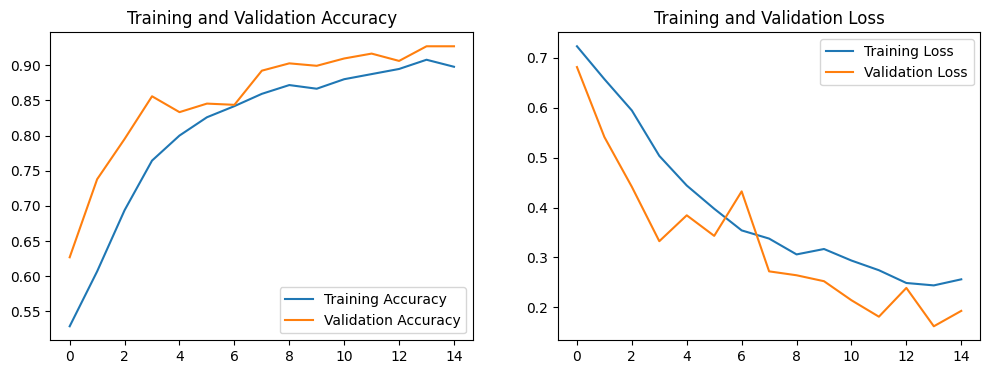

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Submission 

In [8]:
# Load sample submission to get test IDs
submission_df = pd.read_csv(SUBMISSION_FORMAT)
test_filenames = submission_df['id'].tolist()

# Create Test DataFrame
test_df = pd.DataFrame({'id': test_filenames})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,
    x_col='id',
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False
)

# Predict
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Create submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'label': predicted_classes
})

submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")
submission.head()

Found 600 validated image filenames.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step
Submission file 'submission.csv' created successfully.


,id,label
0,img_000279.jpg,1
1,img_000384.jpg,1
2,img_000454.jpg,1
3,img_000250.jpg,0
4,img_000352.jpg,0
